In [1]:
import polars as pl
from pre_snap_prediction.data import process_data
from pre_snap_prediction.modeling import route_clustering

In [2]:
tracking = process_data.read_tracking_csv(2)

In [3]:
player_play = pl.read_csv("../data/player_play.csv", null_values=["NA", ""])

In [4]:
inverse_tracking = process_data.inverse_left_directed_plays(tracking)

In [5]:
route_tracking = process_data.get_route_tracking(inverse_tracking, player_play)
route_tracking = process_data.get_route_direction(route_tracking)
route_tracking = process_data.inverse_right_route(route_tracking)
route_tracking = process_data.process_route_tracking(route_tracking, player_play)

In [6]:
route_features = process_data.compute_route_features(route_tracking)

In [7]:
clusters_route = pl.read_csv("../data/clusters_route.csv", null_values=["NA", ""])

In [8]:
clusters_route_mode = pl.read_csv("../data/clusters_route_mode.csv", null_values=["NA", ""])

In [10]:
clusters_reception_zone = pl.read_csv("../data/clusters_reception_zone.csv", null_values=["NA", ""])

In [11]:
clusters_route_tracking = route_clustering.join_clusters_to_data(route_tracking, clusters_route)

In [16]:
import matplotlib.pyplot as plt

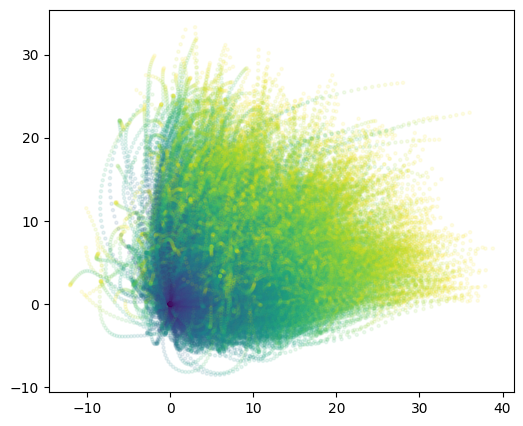

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(
    clusters_route_tracking.filter(pl.col("week")==1)["relative_x"].to_numpy(),
    clusters_route_tracking.filter(pl.col("week")==1)["relative_y"].to_numpy(),
    c=clusters_route_tracking.filter(pl.col("week")==1)["route_frameId"].to_numpy(),
    cmap="viridis",
    s=5,
    alpha=0.1,
)
ax.set_aspect('equal', adjustable='box')


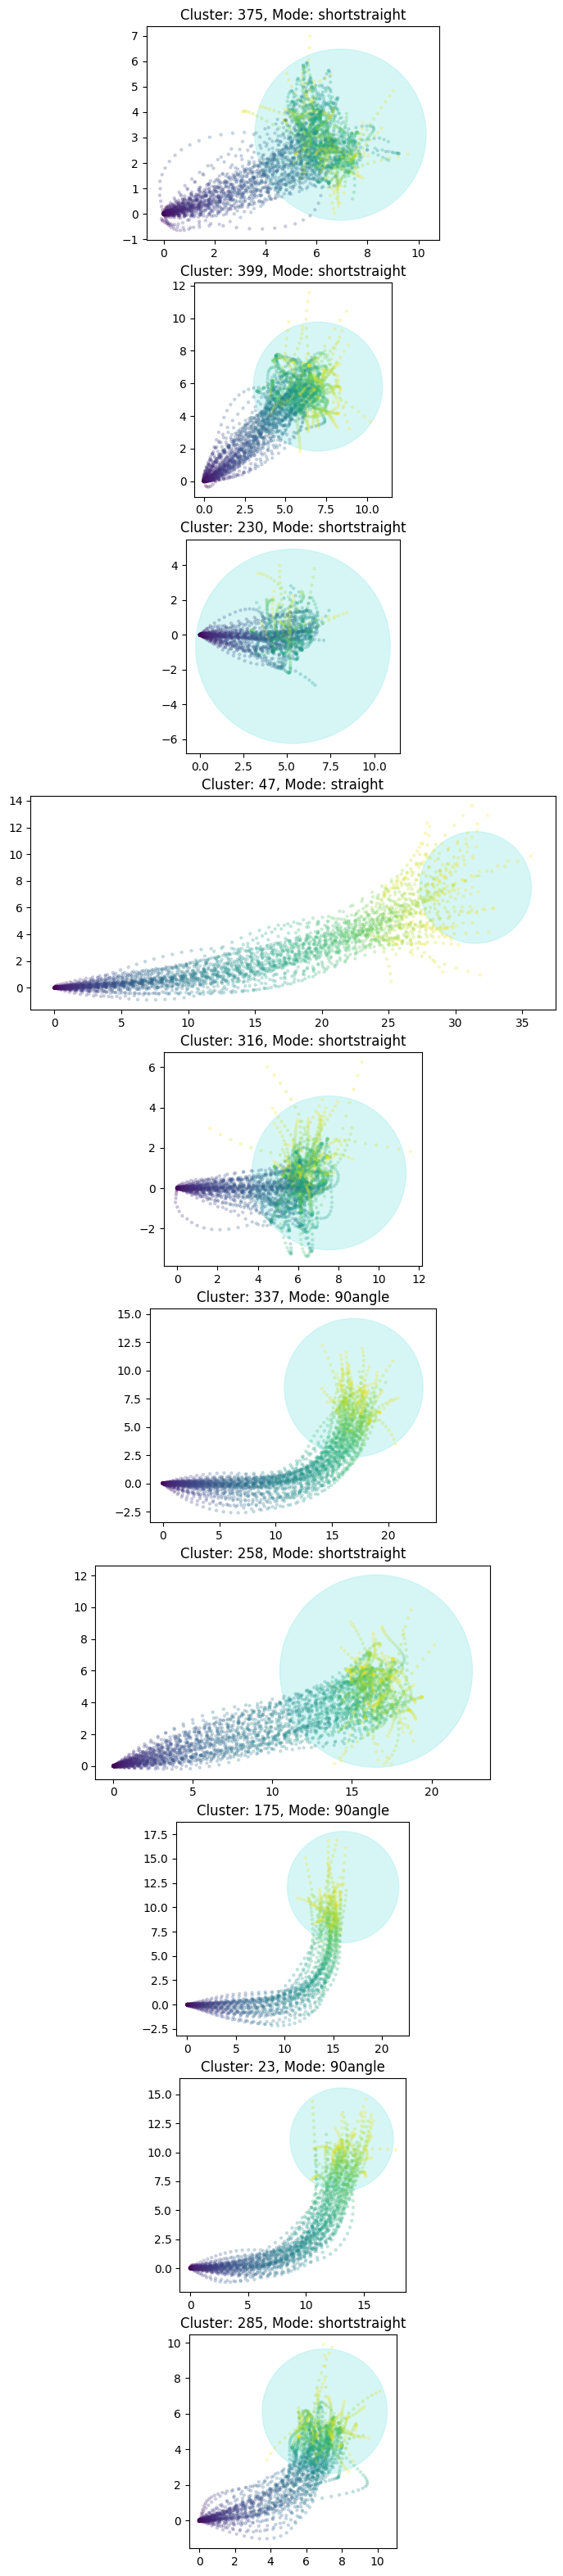

In [24]:
clusters_count = clusters_route["cluster"].value_counts().sort("count", descending=True)
unique_clusters = clusters_count["cluster"][:10]
fig, axs = plt.subplots(len(unique_clusters), 1, figsize=(12,len(unique_clusters)*4))
for i, cluster in enumerate(unique_clusters):
    cluster_reception_zone = clusters_reception_zone.filter(pl.col("cluster")==cluster)
    if cluster_reception_zone.shape[0]>0:
        circle = plt.Circle(
            (
                (cluster_reception_zone["relative_x_min"][0]+cluster_reception_zone["relative_x_max"][0])/2, 
                (cluster_reception_zone["relative_y_min"][0]+cluster_reception_zone["relative_y_max"][0])/2
            ), 
            (
                cluster_reception_zone["relative_x_max"][0] - cluster_reception_zone["relative_x_min"][0] +
                cluster_reception_zone["relative_y_max"][0] - cluster_reception_zone["relative_y_min"][0]
            )/2, 
            color='PaleTurquoise', 
            fill=True, 
            alpha=0.5, 
        )
        axs[i].add_patch(circle)
    
    cluster_route_tracking = clusters_route_tracking.filter(pl.col("cluster")==cluster)
    axs[i].scatter(
        cluster_route_tracking["relative_x"], 
        cluster_route_tracking["relative_y"], 
        c=cluster_route_tracking["route_frameId"], 
        cmap='viridis', 
        s=5, 
        alpha=0.2
    )

    
    axs[i].set_aspect('equal', adjustable='box')
    axs[i].set_title(
        f"Cluster: {cluster}, Mode: {clusters_route_mode.filter(pl.col('cluster')==cluster)['route_mode'][0]}"
    )